In [1]:
import numpy as np
import logging
import typing as t


In [2]:
import razor.flow as rf
from razor.api import datasources, project_space_path


In [3]:
# sftp_client = rf.datasources("system_test_files").client()

In [4]:
config = {'cpu': 1, 'ram': 4048}

In [5]:
# logger=logging.getLogger()

# @rf.block(executor=rf.ProcessExecutor)
# class GenerateData:
#     filename: t.Any
#     out_filename: rf.Output[t.Any]
        
#     def run(self):
#         sftp_client = datasources("system_test_files").client()
#         with sftp_client.open(self.filename, 'w') as f:
#             f.write('1'+'\n')
#             f.write('2'+'\n')
#             f.write('2'+'\n')
#             f.write('4'+'\n')
#             f.write('5')
#         self.out_filename.put(self.filename)
            


In [6]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cpu'], memory=config['ram']))
class STDIn:
    filename: t.Any
    a: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    b: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    c: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
    d: rf.Output[t.Any] = rf.Output(transport=rf.KafkaTransport)
    e: rf.Output[t.Any] = rf.Output(transport=rf.KafkaTransport)
        
    def run(self):
        with open(project_space_path(self.filename), 'r') as f:
            lines = f.readlines()
        
        self.a.put(int(lines[0]))
        self.b.put(int(lines[1]))
        self.c.put(int(lines[2]))
        self.d.put(int(lines[3]))
        self.e.put(int(lines[4]))
        

In [7]:
@rf.block(executor=rf.ProcessExecutor)
class Add1:
    input_1: t.Any
    input_2: t.Any
    sum_output: rf.Output[t.Any] = rf.Output(transport=rf.FileTransport)
        
    def run(self):
        self.logger.info('Running Add block')
        self.logger.info(f'input_1 :{self.input_1}')
        self.logger.info(f'input_2 :{self.input_2}')
        self.sum_output.put((self.input_1 + self.input_2))
        

In [8]:
@rf.block(executor=rf.HorovodExecutor)
class Add2:
    input_1: t.Any
    input_2: t.Any
    sum_output: rf.Output[t.Any] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        self.logger.info('Running Add block')
        self.logger.info(f'input_1 :{self.input_1}')
        self.logger.info(f'input_2 :{self.input_2}')
        self.sum_output.put((self.input_1 + self.input_2))
        

In [9]:
@rf.block(executor=rf.BlockExecutor)
class Multiply1:
    input_sum: t.Any
    input_multiplier: t.Any
    output_mul: rf.Output[t.Any] = rf.Output(transport=rf.KafkaTransport)
    
    def run(self):
        self.logger.info('Running Multiply block')
        self.logger.info(f'input_sum :{self.input_sum}')
        self.logger.info(f'input_multiplier :{self.input_multiplier}')
        self.output_mul.put((self.input_sum * self.input_multiplier))
        
        

In [10]:
@rf.block(executor=rf.ContainerExecutor(cores=config['cpu'], memory=config['ram']))
class Multiply2:
    input_sum: t.Any
    input_multiplier: t.Any
    out_file_name: t.Any
    
    def run(self):
        self.logger.info('Running Multiply block')
        self.logger.info(f'input_sum :{self.input_sum}')
        self.logger.info(f'input_multiplier :{self.input_multiplier}')
        self.result=self.input_sum * self.input_multiplier
        self.logger.info(f'result :{self.result}')
        print("$$", self.result)
        with open(project_space_path(self.out_file_name), 'w') as file:
            file.write(str(self.result))
        
        

In [11]:
fname = "/data/sdk_testbench/executor_transport_test/integer_data.txt"
output_filename = "/data/sdk_testbench/executor_transport_test/tc_31_out.txt"


# generate_data = GenerateData(filename=fname)

stdin = STDIn(filename=fname)

add1 = Add1(input_1=stdin.a, input_2=stdin.b)
#         .sum_output(transport=SocketTransport)


add2 = Add2(input_1=stdin.c, input_2=add1.sum_output)
#         .sum_output(transport=SocketTransport)


mul1 = Multiply1(input_sum=add2.sum_output, input_multiplier=stdin.d)
#         .output_mul(transport=SocketTransport)


mul2 = Multiply2(input_sum=mul1.output_mul, input_multiplier=stdin.e, out_file_name=output_filename)




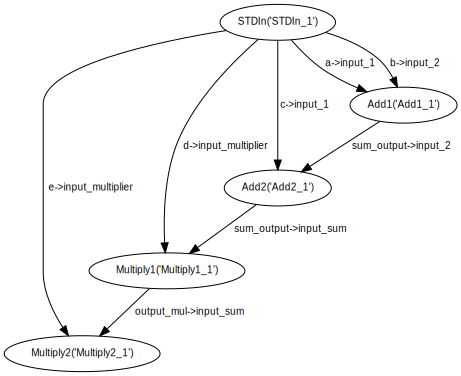

In [12]:
pipeline = rf.Pipeline(name='different_executor_and_transports', targets=[mul2])
pipeline


In [13]:
def create_pipeline():
    return pipeline